# Block Resampling & Z Scores

This code takes in raw climate data from [Met Eireann](http://www.met.ie/climate-request/) then: 
- Computes [Potential Evapotranspiration](https://en.wikipedia.org/wiki/Potential_evaporation) according to the Hargreaves method (chosen due to data availability) 
- Splits the data into seasons according to the climatological year (Winter: DJF, Spring: MAM, Summer: JJA, Autumn: SON)
- Removes seasons which has missing values above a certain threshold
- Calculates temperature and rainfall extremes based on z-scores and standard deviations respectively
- Allows for the selection of certain seasonal characteristics (warm/wet, warm/dry, cold/wet, cold/dry)
- Resamples the observed climate and produces a new sequence which takes extremes into account

### To Do List

TODO:
- Insert check function OR split data into dataframes for each season (winter, spring, summer, autumn + select from there, avoiding check function)

- Use quantiles or ranks instead of std dev and z scores

- check if extremes are becoming more frequent over time (bar chart with regression line) run a random simulation (1000 possible scenarios), regression line this also, compare extremes (values above x are 10% likelier to occur etc)

- Crude measurement of extremes - average for first 20 years vs average for 2nd 20 years and see the difference (is it warming?)

- use a longer dataset and pull out multi-extreme years (do modern years have higher frequency of extremes?)do the same with multi-extreme years (warm/dry, cold/wet etc)

- Overall:
    - Split into seasons
    - Rank
    - Frequency analysis
    - Choose new sequence

1. Generate extreme indices for seasons (warm season, cool season, wet season, dry season)
2. Generate new sequence based on multiple warm years, cool years, wet years, dry years etc. 

### User-Defined Variables (to be coded in if possible)

In [1]:
outputyears = 50 #number of years in your generated sequence

### Load Necessary Packages

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pyeto #install from here (https://github.com/woodcrafty/PyETo), download zip, move to scripts folder in your python
# distribution (/Anaconda/Scripts/PyETo), navigate to this folder in your cmd, type: python setup.py install, restart python
from pyeto import hargreaves
%matplotlib inline

### Read in & display climate data

- maxtp: -  Maximum Air Temperature (C)
- mintp: -  Minimum  Air Temperature (C)
- rain: -	  Precipitation Amount (mm)
- cbl:  -   Mean CBL Pressure (hpa) (CBL - convective boundary layer)
- wdsp: -	  Mean Wind Speed (knot)
- hm: -	  Highest ten minute mean wind speed (knot)		                 
- ddhm: -	  Mean Wind Direction over 10 minutes at time of highest 10 minute mean (degree)                  
- hg: -	  Highest Gust (knot)
- soil  -   Mean 10cm soil temperature (C)
- i: -	  Indicator

Read in met data from different sites 

In [3]:
OakPark = pd.read_csv("E:\PhD\Data\MetData\Raw\dly375 (Oak Park)\dly375.csv",skiprows=16, na_values=[' '])
Valentia = pd.read_csv("E:\PhD\Data\MetData\Valentia\dly2275\dly2275.csv",skiprows=25, na_values=[' '])

In [4]:
df = Valentia
df.head()

,date,imax,maxtp,imin,mintp,irain,rain,cbl,wdsp,ihm,...,hg,sun,dos,g_rad,soil,pe,evap,smd_wd,smd_md,smd_wd.1
0,01-jan-1986,0,9.6,0,0.7,0,21.1,982.1,11.7,0,...,45,1.1,0,NaN,4.700,0.4,0.5,0.0,-10.0,0.0
1,02-jan-1986,0,7.1,0,1.5,0,1.2,983.6,9.8,0,...,37,2.8,0,NaN,4.125,0.3,0.3,0.0,-0.9,0.0
2,03-jan-1986,0,7.5,0,1.6,2,0.0,1005.8,7.9,0,...,28,1.6,0,NaN,3.650,0.4,0.5,0.4,0.4,0.4
3,04-jan-1986,0,10.4,0,3.1,0,19.9,1003.5,13.9,0,...,41,0.1,0,NaN,5.900,0.7,0.9,0.0,-10.0,0.0
4,05-jan-1986,0,6.1,0,0.7,0,8.2,1002.0,11.5,0,...,36,1.4,0,NaN,3.775,0.5,0.7,0.0,-7.7,0.0


Convert 'date' column to datetime object

In [5]:
df['date'] = pd.to_datetime(df['date'], format= '%d-%b-%Y') # https://docs.python.org/2/library/datetime.html see end of this page for %d %m %Y

Find start and end year of the data

In [6]:
no_of_years = df['date'].dt.year #creates a variable for the year column
no_of_years = list(no_of_years) #turns it into a list

In [7]:
startyear = no_of_years[0] #gets the first value
print startyear

endyear = no_of_years[-1] #gets the last value
print endyear

1986
2016


### Create mean temp field

In [8]:
df['meantp'] = (df['maxtp'] + df['mintp'])/2
df.meantp = df.meantp.round(1) #keep Tmean to one decimal place as that's what's in the original dat
#NOTE:Numpy rounds to the nearest even value. Thus 1.5 and 2.5 round to 2.0, -0.5 and 0.5 round to 0.0, etc.

### Calculate PET using [Hargreaves method](https://github.com/woodcrafty/PyETo/blob/master/docs/hargreaves.rst) (from [PyETo package](https://github.com/woodcrafty/PyETo))

The hargreaves method is recommended by the FAO (Allen et al, 1998) where insufficient meterological data are available from Penman-Monteith)

It uses temperature and solar radiation which is estimated from the latitude and the time of year.

The Hargreaves equation has a tendency to under-estimate ETo under high wind conditions(u2 > 3m/s) and to over-estimate under conditions of high relative humidity.

**First specify latitude for your site, and create a 'day of year' column from the date:**

In [9]:
lat = pyeto.deg2rad(52.861) #latitude for Oak Park Carlow

df['lat']= lat #add column to the dataframe

df['dayofyear'] = pd.DatetimeIndex(df['date']).dayofyear #create 'day of year' column to calculate sunshine variables

Estimate solar declination (sol_dec), sunset hour angle (sha), inverse relative distance from Earth to the sun (ird), and ET radiation (et_rad)

In [10]:
sol_dec = df['dayofyear'].apply(pyeto.sol_dec)   # Solar declination
df['sol_dec'] = sol_dec #add column

sha = df.apply(lambda x: pyeto.sunset_hour_angle(x['lat'],x['sol_dec']), axis=1)
df['sha'] = sha #add column

ird = df['dayofyear'].apply(pyeto.inv_rel_dist_earth_sun)
df['ird'] = ird

et_rad = df.apply(lambda x: pyeto.et_rad(x['lat'],x['sol_dec'],x['sha'],x['ird']), axis =1)   # Extraterrestrial radiation
df['et_rad'] = et_rad

df.head()

,date,imax,maxtp,imin,mintp,irain,rain,cbl,wdsp,ihm,...,smd_wd,smd_md,smd_wd.1,meantp,lat,dayofyear,sol_dec,sha,ird,et_rad
0,1986-01-01,0,9.6,0,0.7,0,21.1,982.1,11.7,0,...,0.0,-10.0,0.0,5.1,0.922598,1,-0.401008,0.976637,1.032995,6.083577
1,1986-01-02,0,7.1,0,1.5,0,1.2,983.6,9.8,0,...,0.0,-0.9,0.0,4.3,0.922598,2,-0.399564,0.979348,1.032980,6.134697
2,1986-01-03,0,7.5,0,1.6,2,0.0,1005.8,7.9,0,...,0.4,0.4,0.4,4.6,0.922598,3,-0.398001,0.982272,1.032956,6.190089
3,1986-01-04,0,10.4,0,3.1,0,19.9,1003.5,13.9,0,...,0.0,-10.0,0.0,6.8,0.922598,4,-0.396320,0.985406,1.032922,6.249764
4,1986-01-05,0,6.1,0,0.7,0,8.2,1002.0,11.5,0,...,0.0,-7.7,0.0,3.4,0.922598,5,-0.394522,0.988748,1.032878,6.313735


Apply the 'hargreaves' function

In [11]:
PEcalc = df.apply(lambda x: hargreaves(x['mintp'], x['maxtp'], x['meantp'], x['et_rad']),axis=1)
df['hargreaves'] = PEcalc #create a column
df.head()

,date,imax,maxtp,imin,mintp,irain,rain,cbl,wdsp,ihm,...,smd_md,smd_wd.1,meantp,lat,dayofyear,sol_dec,sha,ird,et_rad,hargreaves
0,1986-01-01,0,9.6,0,0.7,0,21.1,982.1,11.7,0,...,-10.0,0.0,5.1,0.922598,1,-0.401008,0.976637,1.032995,6.083577,0.390012
1,1986-01-02,0,7.1,0,1.5,0,1.2,983.6,9.8,0,...,-0.9,0.0,4.3,0.922598,2,-0.399564,0.979348,1.032980,6.134697,0.301070
2,1986-01-03,0,7.5,0,1.6,2,0.0,1005.8,7.9,0,...,0.4,0.4,4.6,0.922598,3,-0.398001,0.982272,1.032956,6.190089,0.316052
3,1986-01-04,0,10.4,0,3.1,0,19.9,1003.5,13.9,0,...,-10.0,0.0,6.8,0.922598,4,-0.396320,0.985406,1.032922,6.249764,0.389806
4,1986-01-05,0,6.1,0,0.7,0,8.2,1002.0,11.5,0,...,-7.7,0.0,3.4,0.922598,5,-0.394522,0.988748,1.032878,6.313735,0.291882


Compare hargreaves calculation to Met Eireann PE (Penman-Monteith method) (purely to see if the calculation approximates)

In [12]:
metPE = pd.read_excel("E:\PhD\Data\MetData\PE\OakPark 08-16.xlsx")
metPE['date'] = pd.to_datetime(metPE['date'], format= '%d-%b-%Y') #datetime object
metPE = metPE[['date','PE (mm)']]
metPE.head()

,date,PE (mm)
0,2008-01-01,0.546
1,2008-01-02,0.825
2,2008-01-03,0.416
3,2008-01-04,0.390
4,2008-01-05,0.253


Drop 2007 from hargreaves calculation

In [13]:
df2 = df.ix[365:]
df2 = df2[['date','hargreaves']]
df2.head()

,date,hargreaves
365,1987-01-01,0.339115
366,1987-01-02,0.333439
367,1987-01-03,0.409101
368,1987-01-04,0.321390
369,1987-01-05,0.227607


Merge the two dataframes

**Calculate seasonal sums and compare (percentage bias)**

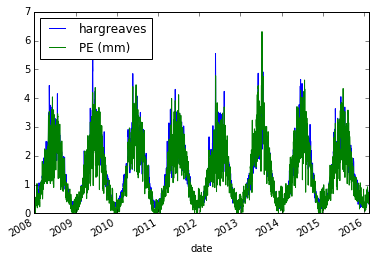

In [14]:
compare = df2.merge(metPE, on = 'date')
compare.head()
compare.plot(x='date')

Filter out unwanted columns (Model only needs temp, PE and rainfall)

In [15]:
df = df[['date','meantp','hargreaves','rain']]
df.head()

,date,meantp,hargreaves,rain
0,1986-01-01,5.1,0.390012,21.1
1,1986-01-02,4.3,0.301070,1.2
2,1986-01-03,4.6,0.316052,0.0
3,1986-01-04,6.8,0.389806,19.9
4,1986-01-05,3.4,0.291882,8.2


Convert 'date' column to datetime object so Pandas can use it 

Split data into seasons based on months

Winter = 1, Spring = 2, Summer = 3, Autumn = 4

In [16]:
#create a season function to split data into seasons
def get_season(row):
    if row['date'].month >= 3 and row['date'].month <= 5:
        return '2'
    elif row['date'].month >= 6 and row['date'].month <= 8:
        return '3'
    elif row['date'].month >= 9 and row['date'].month <= 11:
        return '4'
    else:
        return '1'

Apply the season function to the data

In [17]:
df['Season'] = df.apply(get_season, axis=1)

C:\Users\pflattery\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Create 'Year' column from the 'date' column

In [18]:
df['Year'] = df['date'].dt.year

C:\Users\pflattery\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Make December of previous year part of winter for current year (to keep climatolgical year) 

In [19]:
#Redefine the year to attach December of previous year to winter of following year 
#Everywhere the month is '12', the year column gets increased by 1. 
df.loc[df['date'].dt.month == 12, 'Year'] += 1
df.head()

C:\Users\pflattery\AppData\Local\Continuum\Anaconda\lib\site-packages\pandas\core\indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,date,meantp,hargreaves,rain,Season,Year
0,1986-01-01,5.1,0.390012,21.1,1,1986
1,1986-01-02,4.3,0.301070,1.2,1,1986
2,1986-01-03,4.6,0.316052,0.0,1,1986
3,1986-01-04,6.8,0.389806,19.9,1,1986
4,1986-01-05,3.4,0.291882,8.2,1,1986


Create a new dataframe indexed by Year and Season

In [20]:
#how to multiindex from here: http://stackoverflow.com/questions/33435971/selecting-time-series-data-in-a-specific-sequence-using-pandas/33437422#33437422
df2 = df.set_index(['Year', 'Season'], inplace=False)
df2.head()

date  meantp  hargreaves  rain
Year Season                                     
1986 1      1986-01-01     5.1    0.390012  21.1
     1      1986-01-02     4.3    0.301070   1.2
     1      1986-01-03     4.6    0.316052   0.0
     1      1986-01-04     6.8    0.389806  19.9
     1      1986-01-05     3.4    0.291882   8.2

# Remove incomplete seasons and apply missing value threshold
Count the values in each season (also indicates missing values)

Number of days in:
- 1 (Winter): 90 (91 in Leap Year - how to deal with this?) 
- 2 (Spring): 92
- 3 (Summer): 92
- 4 (Autumn): 91

In [21]:
count = df2.groupby(level=[0, 1]).count()
count

date  meantp  hargreaves  rain
Year Season                                
1986 1         59      59          59    59
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1987 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1988 1         91      91          91    91
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1989 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1990 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1991 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1992 1         91      91          91    91
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1993 1         90      90          90    90
     2         92      92          92    92
...           ...     ...         ...   ...
2009 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2010 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2011 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2012 1         91      91          91    91
     2         91      91          91    91
     3         92      92          92    91
     4         91      91          91    91
2013 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2014 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2015 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2016 1         91      91          91    91
     2         31      31          31    31

[122 rows x 4 columns]

Create a 'complete' variable with only complete months of data (75 is completely arbitrary - code this in up top)

In [22]:
complete = count[count['rain'] >= 75].index #counts seasons with more than 75 values for rain

Create an index for the values in the dataframe which match the 'complete' index

In [23]:
idx = df2.index.isin(complete)
idx #first are false, as the first season (Winter 2007) does not have enough days in it (missing December 2006)

array([False, False, False, ..., False, False, False], dtype=bool)

In [24]:
df = df[idx]
df

,date,meantp,hargreaves,rain,Season,Year
59,1986-03-01,1.2,0.621590,0.0,2,1986
60,1986-03-02,2.9,1.134670,0.0,2,1986
61,1986-03-03,2.8,1.199563,4.0,2,1986
62,1986-03-04,10.0,0.699560,3.9,2,1986
63,1986-03-05,6.8,0.935676,0.7,2,1986
64,1986-03-06,6.5,0.912963,3.0,2,1986
65,1986-03-07,6.2,1.315927,0.0,2,1986
66,1986-03-08,9.2,1.016681,10.4,2,1986
67,1986-03-09,8.1,0.937120,1.3,2,1986
68,1986-03-10,8.0,0.815076,0.0,2,1986


In [25]:
df2 = df.set_index(['Year', 'Season'], inplace=False)
df2

date  meantp  hargreaves  rain
Year Season                                     
1986 2      1986-03-01     1.2    0.621590   0.0
     2      1986-03-02     2.9    1.134670   0.0
     2      1986-03-03     2.8    1.199563   4.0
     2      1986-03-04    10.0    0.699560   3.9
     2      1986-03-05     6.8    0.935676   0.7
     2      1986-03-06     6.5    0.912963   3.0
     2      1986-03-07     6.2    1.315927   0.0
     2      1986-03-08     9.2    1.016681  10.4
     2      1986-03-09     8.1    0.937120   1.3
     2      1986-03-10     8.0    0.815076   0.0
     2      1986-03-11     9.4    0.627307  13.6
     2      1986-03-12     7.1    1.148489  15.7
     2      1986-03-13     6.4    1.432751   5.6
     2      1986-03-14    10.8    0.712623   0.3
     2      1986-03-15     9.7    1.012534  12.0
     2      1986-03-16     6.3    1.163051   3.7
     2      1986-03-17     7.0    1.340059  16.4
     2      1986-03-18     5.6    1.201557   0.4
     2      1986-03-19     6.6    1.589205  16.1
     2      1986-03-20     7.8    1.363832   1.4
     2      1986-03-21     9.0    1.062747   8.8
     2      1986-03-22    10.0    1.414229   1.7
     2      1986-03-23     5.2    1.382158  11.7
     2      1986-03-24     4.9    1.373865   8.0
     2      1986-03-25     6.0    1.238934   2.9
     2      1986-03-26     7.4    1.587558   8.9
     2      1986-03-27     6.6    1.516583   4.5
     2      1986-03-28     7.3    1.281632   7.4
     2      1986-03-29     4.8    1.168891  10.5
     2      1986-03-30     6.6    1.304424   7.3
...                ...     ...         ...   ...
2016 1      2016-01-31     9.4    0.590166   3.5
     1      2016-02-01     9.9    0.552521   1.4
     1      2016-02-02     6.4    0.454738   5.2
     1      2016-02-03     7.1    0.605146   1.8
     1      2016-02-04    10.2    0.372206   1.4
     1      2016-02-05     7.8    0.568397  13.8
     1      2016-02-06     6.6    0.578765  16.6
     1      2016-02-07     7.6    0.701316  13.5
     1      2016-02-08     6.3    0.514592   9.4
     1      2016-02-09     4.8    0.531409   3.4
     1      2016-02-10     7.0    0.543827   1.4
     1      2016-02-11     6.1    0.486563   3.7
     1      2016-02-12     7.0    0.572067   0.2
     1      2016-02-13     6.4    0.601985  17.1
     1      2016-02-14     5.4    0.562693   2.4
     1      2016-02-15     4.1    0.778914   0.0
     1      2016-02-16     8.1    0.731339  43.6
     1      2016-02-17     4.7    0.647501   5.4
     1      2016-02-18     4.8    0.743748   3.5
     1      2016-02-19     8.2    0.677004   3.8
     1      2016-02-20    10.4    0.560351   1.9
     1      2016-02-21     9.5    0.781564   1.4
     1      2016-02-22     5.8    0.695685   0.9
     1      2016-02-23     5.2    0.997176   0.2
     1      2016-02-24     4.4    0.822500   0.4
     1      2016-02-25     4.1    0.826228  12.3
     1      2016-02-26     5.4    0.536422  12.8
     1      2016-02-27     5.4    0.838922   6.7
     1      2016-02-28     4.6    1.012627   0.0
     1      2016-02-29     9.4    0.899689   6.4

[10957 rows x 4 columns]

In [26]:
df2['rainrank'] = df2['rain'].rank()
df2['trmprank'] = df2['meantp'].rank()
df2.head()

date  meantp  hargreaves  rain  rainrank  trmprank
Year Season                                                         
1986 2      1986-03-01     1.2    0.621590   0.0    1545.0      37.0
     2      1986-03-02     2.9    1.134670   0.0    1545.0     140.0
     2      1986-03-03     2.8    1.199563   4.0    7420.5     129.0
     2      1986-03-04    10.0    0.699560   3.9    7361.0    4467.0
     2      1986-03-05     6.8    0.935676   0.7    4598.5    1477.5

Histogram

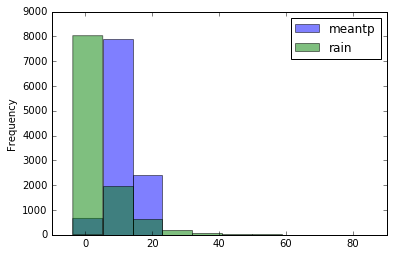

In [27]:
df2[['meantp','rain']].plot.hist(alpha=0.5)

Print the entire dataframe to check it (can remove this section as it does it correctly)

In [28]:
with pd.option_context('display.max_rows', 999, 'display.max_columns', 6):
    print df

            date  meantp  hargreaves  rain Season  Year
59    1986-03-01     1.2    0.621590   0.0      2  1986
60    1986-03-02     2.9    1.134670   0.0      2  1986
61    1986-03-03     2.8    1.199563   4.0      2  1986
62    1986-03-04    10.0    0.699560   3.9      2  1986
63    1986-03-05     6.8    0.935676   0.7      2  1986
64    1986-03-06     6.5    0.912963   3.0      2  1986
65    1986-03-07     6.2    1.315927   0.0      2  1986
66    1986-03-08     9.2    1.016681  10.4      2  1986
67    1986-03-09     8.1    0.937120   1.3      2  1986
68    1986-03-10     8.0    0.815076   0.0      2  1986
69    1986-03-11     9.4    0.627307  13.6      2  1986
70    1986-03-12     7.1    1.148489  15.7      2  1986
71    1986-03-13     6.4    1.432751   5.6      2  1986
72    1986-03-14    10.8    0.712623   0.3      2  1986
73    1986-03-15     9.7    1.012534  12.0      2  1986
74    1986-03-16     6.3    1.163051   3.7      2  1986
75    1986-03-17     7.0    1.340059  16.4      

Calculate number of seasons in the dataset (to calculate seasonal rainfall means later)

In [29]:
seascount = df2.groupby(level=[0,1]).count() #counting number of seasons (to divide for avg seasonal rainfall later)
seascount

date  meantp  hargreaves  rain  rainrank  trmprank
Year Season                                                    
1986 2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
1987 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
1988 1         91      91          91    91        91        91
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
1989 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
1990 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
1991 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
1992 1         91      91          91    91        91        91
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
1993 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
...           ...     ...         ...   ...       ...       ...
2008 4         91      91          91    91        91        91
2009 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
2010 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
2011 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
2012 1         91      91          91    91        91        91
     2         91      91          91    91        91        91
     3         92      92          92    91        91        92
     4         91      91          91    91        91        91
2013 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
2014 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
2015 1         90      90          90    90        90        90
     2         92      92          92    92        92        92
     3         92      92          92    92        92        92
     4         91      91          91    91        91        91
2016 1         91      91          91    91  

In [30]:
seasoncount = df.reset_index().groupby('Season')['Year'].nunique()
print seasoncount

Season
1    30
2    30
3    30
4    30
Name: Year, dtype: int64


# Temperature Extremes

Calculate mean values for each season

In [31]:
seasmean = df['meantp'].groupby(df['Season']).mean()
print seasmean #check the averages - do they seem correct? Yes

Season
1     7.602917
2     9.711018
3    14.688007
4    11.733919
Name: meantp, dtype: float64


Calculating differences between season and season means & adding a zscore column

In [32]:
df2['seasdif'] = df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean #creates an anomaly column
seasdif = df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean #creates a series

df2['tempzscore'] = (df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean) / df2['meantp'].groupby(level=['Year','Season']).std() #calculates z-scores
tempzscore = (df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean) / df2['meantp'].groupby(level=['Year','Season']).std() #series

print seasdif
print df2.head()

Year  Season
1986  2        -1.846888
      3        -1.159746
      4        -0.639414
1987  1        -0.845140
      2        -0.316453
      3        -0.221703
      4        -1.109744
1988  1        -0.171049
      2         0.065068
      3        -0.743442
      4        -0.633919
1989  1         1.153749
      2        -0.349062
      3         0.766341
      4        -0.082271
1990  1         0.161527
      2         0.654199
      3         0.261993
      4        -0.381172
1991  1        -1.465140
      2         0.059634
      3         0.035906
      4        -0.127326
1992  1         0.357522
      2         0.613982
      3        -0.167355
      4        -1.627326
1993  1         0.262638
      2        -0.006671
      3        -0.599964
                  ...   
2008  4        -0.536117
2009  1        -0.142917
      2         0.430286
      3         0.313080
      4         0.346300
2010  1        -2.389584
      2        -0.081671
      3         0.326123
      4     

Visualise the seasonal differences (illustrative only - to get an idea of variation)

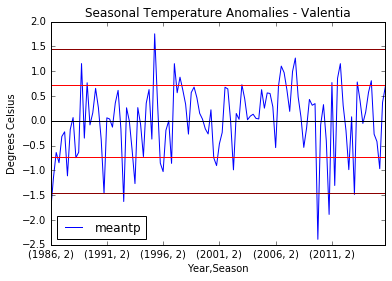

In [33]:
#visualise the seasonal differences (calculate greater than 2 standard deviations?)
seasdif.plot()
plt.axhline(0,color='black')
plt.axhline(seasdif.std() * 1, color ='red')
plt.axhline(-(seasdif.std()) * 1, color ='red')
plt.axhline(seasdif.std() * 2, color ='darkred')
plt.axhline(-(seasdif.std()) * 2, color ='darkred')
plt.title('Seasonal Temperature Anomalies - Valentia')
plt.legend(loc='best') #handy trick
plt.ylabel('Degrees Celsius')
plt.savefig('C:\Users\pflattery\Dropbox\Programming\Jupyter\Python\ValentiaAnomaly2.png', dpi=500) #Save the figure

### Z score comparison

Plot the Z-Score column (two different ways, to see if both methods did the same thing)

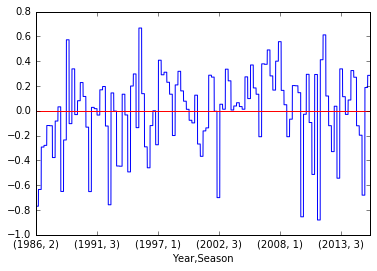

In [34]:
df2['tempzscore'].plot()
plt.axhline(0, color ='red')

In [35]:
seaszscore = (df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean) / df2['meantp'].groupby(level=['Year','Season']).std()
seaszscore = pd.DataFrame(seaszscore)
seaszscore

meantp
Year Season          
1986 2      -0.769264
     3      -0.634432
     4      -0.292275
1987 1      -0.278750
     2      -0.118582
     3      -0.120394
     4      -0.377100
1988 1      -0.082586
     2       0.031874
     3      -0.650320
     4      -0.235248
1989 1       0.572564
     2      -0.103593
     3       0.338030
     4      -0.030531
1990 1       0.081179
     2       0.227818
     3       0.115653
     4      -0.131771
1991 1      -0.651485
     2       0.027618
     3       0.017227
     4      -0.034342
1992 1       0.169258
     2       0.196009
     3      -0.122721
     4      -0.757797
1993 1       0.144048
     2      -0.002375
     3      -0.445184
...               ...
2008 4      -0.208905
2009 1      -0.067396
     2       0.203365
     3       0.201838
     4       0.146060
2010 1      -0.854843
     2      -0.027777
     3       0.294185
     4      -0.094534
2011 1      -0.513022
     2       0.292920
     3      -0.880543
     4       0.411706
2012 1       0.612137
     2       0.119331
     3      -0.120049
     4      -0.329091
2013 1       0.036839
     2      -0.543417
     3       0.337950
     4       0.113824
2014 1      -0.029034
     2       0.087114
     3       0.324355
     4       0.270693
2015 1      -0.120727
     2      -0.196846
     3      -0.680169
     4       0.187775
2016 1       0.285750

[120 rows x 1 columns]

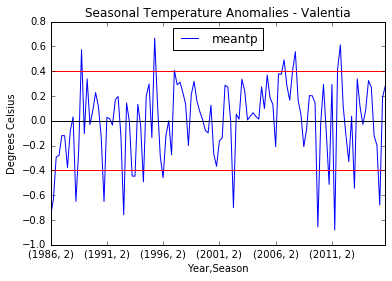

In [36]:
seaszscore.plot()
plt.axhline(0,color='black')
plt.axhline(0.4, color ='red')
plt.axhline(-0.4, color ='red')
plt.title('Seasonal Temperature Anomalies - Valentia')
plt.legend(loc='upper center') #handy trick
plt.ylabel('Degrees Celsius')
plt.savefig('ValentiaAnomaly.png', dpi=500) #Save the figure

Histogram

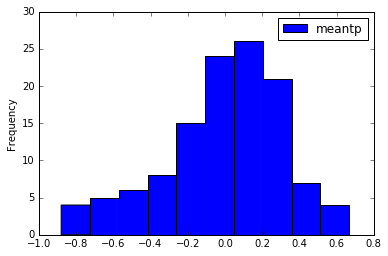

In [37]:
seaszscore.plot.hist()

# Rainfall Extremes

Calculate sum values for each season

In [38]:
rainsum = df['rain'].groupby(df['Season']).sum() / seasoncount #seasonal sums divided by number of years to get baseline rainfall
print rainsum #checked this in Excel, the division is correct

Season
1    489.170000
2    309.310000
3    319.843333
4    467.200000
dtype: float64


In [39]:
raindif = df2['rain'].groupby(level=['Year','Season']).sum() - rainsum #work out the anomalies
raindif

Year  Season
1986  2         132.490000
      3          41.156667
      4        -129.800000
1987  1         -21.170000
      2        -122.010000
      3         -74.343333
      4          32.200000
1988  1          69.030000
      2          11.790000
      3          63.256667
      4         -56.600000
1989  1         -68.970000
      2           1.590000
      3         -88.743333
      4         -93.700000
1990  1          53.130000
      2        -147.610000
      3         -47.443333
      4        -106.200000
1991  1         -45.470000
      2           9.190000
      3         -79.143333
      4          33.400000
1992  1        -244.970000
      2          68.390000
      3          46.356667
      4        -129.500000
1993  1        -149.970000
      2         -11.910000
      3         -59.143333
                   ...    
2008  4         -24.000000
2009  1         -39.170000
      2          43.690000
      3         299.856667
      4         191.100000
2010  1        

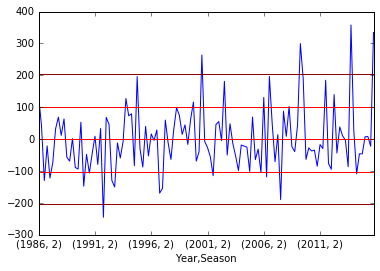

In [40]:
#visualise the seasonal differences - does this method make sense?
raindif.plot()
plt.axhline(0,color='red')
plt.axhline(raindif.std() * 1, color ='red')
plt.axhline(-(raindif.std()) * 1, color ='red')
plt.axhline(raindif.std() * 2, color ='darkred')
plt.axhline(-(raindif.std()) * 2, color ='darkred')

# Extracting extreme seasons

Create a copy of the dataframe and two blank lists for hot and cold extremes

In [41]:
seasdif2 = pd.DataFrame(seasdif)
warm = []
cold = []

Create a function which identifies warm and cold extremes based on the data

Currently uses 1 standard deviation as the threshold, could use a z-score?

In [42]:
def extremetemp(x):
    for season in x:
        if season > x.std() * 1:
            warm.append(1)
        else:
            warm.append(0)

    for season in x:
        if season < (-(x.std()*1)):
            cold.append(1)
        else:
            cold.append(0)

Apply the function to the dataset

In [43]:
extremetemp(seasdif)

Create new columns in duplicate dataset to identify which season has an extreme value

In [44]:
seasdif2['cold']=cold
seasdif2['warm']=warm
seasdif2

meantp  cold  warm
Year Season                      
1986 2      -1.846888     1     0
     3      -1.159746     1     0
     4      -0.639414     0     0
1987 1      -0.845140     1     0
     2      -0.316453     0     0
     3      -0.221703     0     0
     4      -1.109744     1     0
1988 1      -0.171049     0     0
     2       0.065068     0     0
     3      -0.743442     1     0
     4      -0.633919     0     0
1989 1       1.153749     0     1
     2      -0.349062     0     0
     3       0.766341     0     1
     4      -0.082271     0     0
1990 1       0.161527     0     0
     2       0.654199     0     0
     3       0.261993     0     0
     4      -0.381172     0     0
1991 1      -1.465140     1     0
     2       0.059634     0     0
     3       0.035906     0     0
     4      -0.127326     0     0
1992 1       0.357522     0     0
     2       0.613982     0     0
     3      -0.167355     0     0
     4      -1.627326     1     0
1993 1       0.262638     0     0
     2      -0.006671     0     0
     3      -0.599964     0     0
...               ...   ...   ...
2008 4      -0.536117     0     0
2009 1      -0.142917     0     0
     2       0.430286     0     0
     3       0.313080     0     0
     4       0.346300     0     0
2010 1      -2.389584     1     0
     2      -0.081671     0     0
     3       0.326123     0     0
     4      -0.402051     0     0
2011 1      -1.887362     1     0
     2       0.770503     0     1
     3      -1.304312     1     0
     4       0.857289     0     1
2012 1       1.152028     0     1
     2       0.307663     0     0
     3      -0.196703     0     0
     4      -0.984469     1     0
2013 1       0.080416     0     0
     2      -1.483845     1     0
     3       0.782645     0     1
     4       0.406740     0     0
2014 1      -0.052917     0     0
     2       0.175938     0     0
     3       0.571775     0     0
     4       0.807839     0     1
2015 1      -0.269584     0     0
     2      -0.417540     0     0
     3      -0.965181     1     0
     4       0.370476     0     0
2016 1       0.695984     0     0

[120 rows x 3 columns]

### Do the same for Rainfall

In [45]:
raindif2 = pd.DataFrame(raindif)
wet = []
dry = []

Create a function which identifies wet and dry extremes based on the data

In [46]:
def extremerain(x):
    for season in x:
        if season > x.std() * 1:
            wet.append(1)
        else:
            wet.append(0)

    for season in x:
        if season < (-(x.std()*1)):
            dry.append(1)
        else:
            dry.append(0)

Apply the function to the dataset

In [47]:
extremerain(raindif)

In [48]:
seasdif2['wet']=wet
seasdif2['dry']=dry
seasdif2

meantp  cold  warm  wet  dry
Year Season                                
1986 2      -1.846888     1     0    1    0
     3      -1.159746     1     0    0    0
     4      -0.639414     0     0    0    1
1987 1      -0.845140     1     0    0    0
     2      -0.316453     0     0    0    1
     3      -0.221703     0     0    0    0
     4      -1.109744     1     0    0    0
1988 1      -0.171049     0     0    0    0
     2       0.065068     0     0    0    0
     3      -0.743442     1     0    0    0
     4      -0.633919     0     0    0    0
1989 1       1.153749     0     1    0    0
     2      -0.349062     0     0    0    0
     3       0.766341     0     1    0    0
     4      -0.082271     0     0    0    0
1990 1       0.161527     0     0    0    0
     2       0.654199     0     0    0    1
     3       0.261993     0     0    0    0
     4      -0.381172     0     0    0    1
1991 1      -1.465140     1     0    0    0
     2       0.059634     0     0    0    0
     3       0.035906     0     0    0    0
     4      -0.127326     0     0    0    0
1992 1       0.357522     0     0    0    1
     2       0.613982     0     0    0    0
     3      -0.167355     0     0    0    0
     4      -1.627326     1     0    0    1
1993 1       0.262638     0     0    0    1
     2      -0.006671     0     0    0    0
     3      -0.599964     0     0    0    0
...               ...   ...   ...  ...  ...
2008 4      -0.536117     0     0    0    0
2009 1      -0.142917     0     0    0    0
     2       0.430286     0     0    0    0
     3       0.313080     0     0    1    0
     4       0.346300     0     0    1    0
2010 1      -2.389584     1     0    0    0
     2      -0.081671     0     0    0    0
     3       0.326123     0     0    0    0
     4      -0.402051     0     0    0    0
2011 1      -1.887362     1     0    0    0
     2       0.770503     0     1    0    0
     3      -1.304312     1     0    0    0
     4       0.857289     0     1    1    0
2012 1       1.152028     0     1    0    0
     2       0.307663     0     0    0    0
     3      -0.196703     0     0    1    0
     4      -0.984469     1     0    0    0
2013 1       0.080416     0     0    0    0
     2      -1.483845     1     0    0    0
     3       0.782645     0     1    0    0
     4       0.406740     0     0    0    0
2014 1      -0.052917     0     0    1    0
     2       0.175938     0     0    0    0
     3       0.571775     0     0    0    1
     4       0.807839     0     1    0    0
2015 1      -0.269584     0     0    0    0
     2      -0.417540     0     0    0    0
     3      -0.965181     1     0    0    0
     4       0.370476     0     0    0    0
2016 1       0.695984     0     0    1    0

[120 rows x 5 columns]

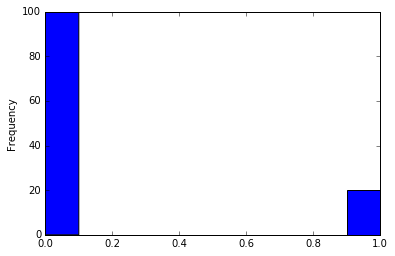

In [49]:
seasdif2['cold'].plot.hist()

### Select out combinations of extremes (warm/wet, warm/dry, cold/wet, cold/dry)

In [50]:
#identify columns with cold extremes (could do the same for warm but there are none)
seasdif2.loc[(seasdif2.cold==1) | (seasdif2.dry==1) | (seasdif2.warm==1) | (seasdif2.wet ==1)]

#TODO: new dataframes for warm, cold, dry and wet years (and warm/wet cold/dry)

meantp  cold  warm  wet  dry
Year Season                                
1986 2      -1.846888     1     0    1    0
     3      -1.159746     1     0    0    0
     4      -0.639414     0     0    0    1
1987 1      -0.845140     1     0    0    0
     2      -0.316453     0     0    0    1
     4      -1.109744     1     0    0    0
1988 3      -0.743442     1     0    0    0
1989 1       1.153749     0     1    0    0
     3       0.766341     0     1    0    0
1990 2       0.654199     0     0    0    1
     4      -0.381172     0     0    0    1
1991 1      -1.465140     1     0    0    0
1992 1       0.357522     0     0    0    1
     4      -1.627326     1     0    0    1
1993 1       0.262638     0     0    0    1
     4      -1.265788     1     0    0    0
1994 1       0.265972     0     0    1    0
1995 1       0.629305     0     0    1    0
     3       1.753297     0     1    0    0
1996 1      -0.853467     1     0    0    0
     2      -1.024062     1     0    0    0
1997 1      -0.858473     1     0    0    1
     2       1.152025     0     1    0    1
     4       0.879267     0     1    0    0
2000 1      -0.162258     0     0    1    0
     4      -0.746007     1     0    1    0
2001 1      -0.902917     1     0    0    0
     4       0.677070     0     0    0    1
2002 3      -0.989094     1     0    0    0
     4       0.147399     0     0    1    0
2003 2       0.727025     0     1    0    0
2006 1       0.281527     0     0    0    1
     2      -0.540366     0     0    1    0
     3       0.695688     0     0    0    1
     4       1.102344     0     1    1    0
2007 1       0.972638     0     1    0    0
     4       0.992454     0     1    0    1
2008 1       1.265215     0     1    0    0
     3       0.075036     0     0    1    0
2009 3       0.313080     0     0    1    0
     4       0.346300     0     0    1    0
2010 1      -2.389584     1     0    0    0
2011 1      -1.887362     1     0    0    0
     2       0.770503     0     1    0    0
     3      -1.304312     1     0    0    0
     4       0.857289     0     1    1    0
2012 1       1.152028     0     1    0    0
     3      -0.196703     0     0    1    0
     4      -0.984469     1     0    0    0
2013 2      -1.483845     1     0    0    0
     3       0.782645     0     1    0    0
2014 1      -0.052917     0     0    1    0
     3       0.571775     0     0    0    1
     4       0.807839     0     1    0    0
2015 3      -0.965181     1     0    0    0
2016 1       0.695984     0     0    1    0

Count extreme values in each year

In [51]:
extremecount = seasdif2.groupby(level=[0]).sum()
extremecount

,meantp,cold,warm,wet,dry
Year,,,,,
1986,-3.646048,2,0,1,1
1987,-2.493039,2,0,0,1
1988,-1.483342,1,0,0,0
1989,1.488757,0,2,0,0
1990,0.696547,0,0,0,2
1991,-1.496926,1,0,0,0
1992,-0.823177,1,0,0,2
1993,-1.609784,1,0,0,1
1994,-0.175801,0,0,1,0


OLS regression on this data

Plot frequency of extremes

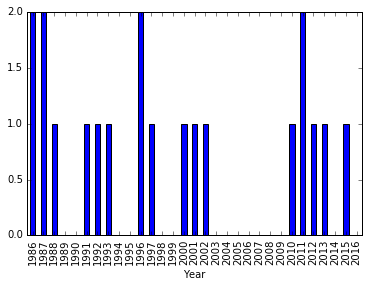

In [52]:
extremecount['cold'].plot(kind='bar')

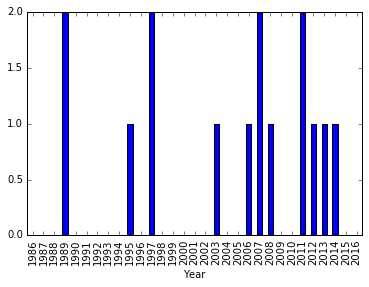

In [53]:
extremecount['warm'].plot(kind='bar')

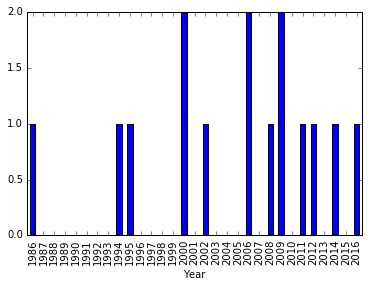

In [54]:
extremecount['wet'].plot(kind='bar')

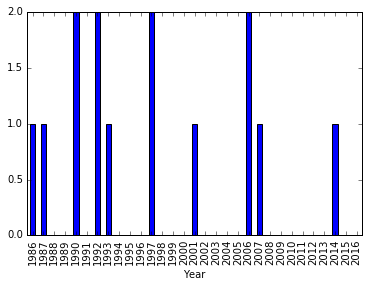

In [55]:
extremecount['dry'].plot(kind='bar')

warm/wet

In [56]:
seasdif2.loc[(seasdif2.warm==1) & (seasdif2.wet ==1)]

,,meantp,cold,warm,wet,dry
Year,Season,,,,,
2006,4,1.102344,0,1,1,0
2011,4,0.857289,0,1,1,0


warm/dry

In [57]:
seasdif2.loc[(seasdif2.warm==1) & (seasdif2.dry ==1)]

,,meantp,cold,warm,wet,dry
Year,Season,,,,,
1997,2,1.152025,0,1,0,1
2007,4,0.992454,0,1,0,1


cold/dry

In [58]:
seasdif2.loc[(seasdif2.cold==1) & (seasdif2.dry==1)]

,,meantp,cold,warm,wet,dry
Year,Season,,,,,
1992,4,-1.627326,1,0,0,1
1997,1,-0.858473,1,0,0,1


cold/wet

In [59]:
seasdif2.loc[(seasdif2.cold==1) & (seasdif2.wet ==1)]

,,meantp,cold,warm,wet,dry
Year,Season,,,,,
1986,2,-1.846888,1,0,1,0
2000,4,-0.746007,1,0,1,0


### Create new extreme dataframes

In [60]:
extremecold = seasdif2.loc[(seasdif2.cold==1)]
extremecold

meantp  cold  warm  wet  dry
Year Season                                
1986 2      -1.846888     1     0    1    0
     3      -1.159746     1     0    0    0
1987 1      -0.845140     1     0    0    0
     4      -1.109744     1     0    0    0
1988 3      -0.743442     1     0    0    0
1991 1      -1.465140     1     0    0    0
1992 4      -1.627326     1     0    0    1
1993 4      -1.265788     1     0    0    0
1996 1      -0.853467     1     0    0    0
     2      -1.024062     1     0    0    0
1997 1      -0.858473     1     0    0    1
2000 4      -0.746007     1     0    1    0
2001 1      -0.902917     1     0    0    0
2002 3      -0.989094     1     0    0    0
2010 1      -2.389584     1     0    0    0
2011 1      -1.887362     1     0    0    0
     3      -1.304312     1     0    0    0
2012 4      -0.984469     1     0    0    0
2013 2      -1.483845     1     0    0    0
2015 3      -0.965181     1     0    0    0

**Get the index to re-index the dataframe**

In [61]:
coldindex = extremecold.index.tolist()
coldindex

[(1986L, '2'),
 (1986L, '3'),
 (1987L, '1'),
 (1987L, '4'),
 (1988L, '3'),
 (1991L, '1'),
 (1992L, '4'),
 (1993L, '4'),
 (1996L, '1'),
 (1996L, '2'),
 (1997L, '1'),
 (2000L, '4'),
 (2001L, '1'),
 (2002L, '3'),
 (2010L, '1'),
 (2011L, '1'),
 (2011L, '3'),
 (2012L, '4'),
 (2013L, '2'),
 (2015L, '3')]

In [62]:
extremecold = df2.loc[coldindex]
extremecold

date  meantp  hargreaves  rain  rainrank  trmprank  \
Year Season                                                            
1986 2      1986-03-01     1.2    0.621590   0.0    1545.0      37.0   
     2      1986-03-02     2.9    1.134670   0.0    1545.0     140.0   
     2      1986-03-03     2.8    1.199563   4.0    7420.5     129.0   
     2      1986-03-04    10.0    0.699560   3.9    7361.0    4467.0   
     2      1986-03-05     6.8    0.935676   0.7    4598.5    1477.5   
     2      1986-03-06     6.5    0.912963   3.0    6791.5    1286.5   
     2      1986-03-07     6.2    1.315927   0.0    1545.0    1098.5   
     2      1986-03-08     9.2    1.016681  10.4    9485.0    3567.5   
     2      1986-03-09     8.1    0.937120   1.3    5372.5    2485.5   
     2      1986-03-10     8.0    0.815076   0.0    1545.0    2396.0   
     2      1986-03-11     9.4    0.627307  13.6    9941.5    3785.5   
     2      1986-03-12     7.1    1.148489  15.7   10177.0    1712.5   
     2      1986-03-13     6.4    1.432751   5.6    8188.0    1216.5   
     2      1986-03-14    10.8    0.712623   0.3    3872.0    5314.5   
     2      1986-03-15     9.7    1.012534  12.0    9720.5    4137.0   
     2      1986-03-16     6.3    1.163051   3.7    7218.0    1153.0   
     2      1986-03-17     7.0    1.340059  16.4   10251.0    1631.0   
     2      1986-03-18     5.6    1.201557   0.4    4093.0     805.5   
     2      1986-03-19     6.6    1.589205  16.1   10216.0    1353.5   
     2      1986-03-20     7.8    1.363832   1.4    5480.0    2239.5   
     2      1986-03-21     9.0    1.062747   8.8    9146.0    3341.5   
     2      1986-03-22    10.0    1.414229   1.7    5793.0    4467.0   
     2      1986-03-23     5.2    1.382158  11.7    9670.0     630.5   
     2      1986-03-24     4.9    1.373865   8.0    8970.5     519.0   
     2      1986-03-25     6.0    1.238934   2.9    6725.0     996.0   
     2      1986-03-26     7.4    1.587558   8.9    9169.0    1930.5   
     2      1986-03-27     6.6    1.516583   4.5    7680.5    1353.5   
     2      1986-03-28     7.3    1.281632   7.4    8781.0    1858.0   
     2      1986-03-29     4.8    1.168891  10.5    9503.0     480.0   
     2      1986-03-30     6.6    1.304424   7.3    8754.0    1353.5   
...                ...     ...         ...   ...       ...       ...   
2015 3      2015-08-02    14.8    2.129900  22.7   10625.0    9215.5   
     3      2015-08-03    14.4    2.204168  12.9    9848.5    8809.0   
     3      2015-08-04    13.8    2.305310   2.2    6225.5    8223.5   
     3      2015-08-05    13.4    2.186717  17.4   10335.0    7842.0   
     3      2015-08-06    12.6    2.521264   0.0    1545.0    7063.5   
     3      2015-08-07    11.2    3.043735   0.0    1545.0    5750.0   
     3      2015-08-08    12.2    2.667013   9.2    9237.0    6696.5   
     3      2015-08-09    15.0    1.706328   2.9    6725.0    9421.0   
     3      2015-08-10    14.0    2.103552   1.8    5884.0    8443.0   
     3      2015-08-11    12.8    2.644445   0.1    3269.0    7250.0   
     3      2015-08-12    11.8    2.906033   0.0    1545.0    6314.0   
     3      2015-08-13    11.8    2.930297   0.0    1545.0    6314.0   
     3      2015-08-14    13.4    2.121621   0.5    4288.5    7842.0   
     3      2015-08-15    14.1    2.416696   0.0    1545.0    8542.5   
     3      2015-08-16    14.4    2.131546   4.4    7633.5    8809.0   
     3      2015-08-17    15.8    1.860349   0.8    4739.5   10052.5   
     3      2015-08-18    15.9    2.266262   8.1    8997.5   10121.0   
     3      2015-08-19    15.1    1.416059   4.4    7633.5    9510.0   
     3      2015-08-20    16.2    1.946446   5.5    8149.5   10299.0   
     3      2015-08-21    15.4    2.059004   0.7    4598.5    9757.0   
     3      2015-08-22    14.6    2.332701   0.7    4598.5    9009.5   
     3      2015-08-23    12.9    2.385660   0.0    1545.0    7346.0   
     3      2015-08-24    12.9    1.786703   2.4    6396.0

### Resample the data and create a new seqence

In [63]:
#blank dataframe
future = pd.DataFrame()

In [64]:
df2.head()

date  meantp  hargreaves  rain  rainrank  trmprank  \
Year Season                                                            
1986 2      1986-03-01     1.2    0.621590   0.0    1545.0      37.0   
     2      1986-03-02     2.9    1.134670   0.0    1545.0     140.0   
     2      1986-03-03     2.8    1.199563   4.0    7420.5     129.0   
     2      1986-03-04    10.0    0.699560   3.9    7361.0    4467.0   
     2      1986-03-05     6.8    0.935676   0.7    4598.5    1477.5   

              seasdif  tempzscore  
Year Season                        
1986 2      -1.846888   -0.769264  
     2      -1.846888   -0.769264  
     2      -1.846888   -0.769264  
     2      -1.846888   -0.769264  
     2      -1.846888   -0.769264

In [65]:
df3 = df2[['meantp','hargreaves','rain']]
df3.head()

meantp  hargreaves  rain
Year Season                          
1986 2          1.2    0.621590   0.0
     2          2.9    1.134670   0.0
     2          2.8    1.199563   4.0
     2         10.0    0.699560   3.9
     2          6.8    0.935676   0.7

**Split into seasonal dataframes**

In [66]:
winters = df3.query('Season == "1"')
springs = df3.query('Season == "2"')
summers = df3.query('Season == "3"')
autumns = df3.query('Season == "4"')

autumns.head()

meantp  hargreaves  rain
Year Season                          
1986 4         14.5    1.451431   1.0
     4         13.6    1.468724   2.5
     4         11.3    2.369189   0.0
     4          9.6    2.456194   0.0
     4         12.4    1.852577   0.0

**Select seasons from each dataframe in sequence**

**This code samples the dataframe randomly, doesn't sample the individual seasons**

In [67]:
dfs = []
for i in range(100):
    dfs.append(df3.query("Year == %d and Season == '1'"  %np.random.choice(no_of_years, 1)))
    dfs.append(df3.query("Year == %d and Season == '2'"  %np.random.choice(no_of_years, 1)))
    dfs.append(df3.query("Year == %d and Season == '3'"  %np.random.choice(no_of_years, 1)))
    dfs.append(df3.query("Year == %d and Season == '4'"  %np.random.choice(no_of_years, 1)))

rnd = pd.concat(dfs)
rnd    

meantp  hargreaves  rain
Year Season                          
1996 1         10.5    0.322571   4.6
     1         13.0    0.320302   9.0
     1         11.2    0.402980   4.0
     1          6.5    0.410271   0.0
     1          5.8    0.289053   0.0
     1          1.5    0.276457   0.0
     1          1.6    0.340885   0.0
     1          8.4    0.374620   0.0
     1          9.4    0.382630   0.0
     1          6.7    0.381809   0.0
     1          7.0    0.484315   0.0
     1          4.8    0.404676   0.0
     1          6.4    0.326145   0.0
     1          5.3    0.242002   0.0
     1          4.6    0.150847   0.0
     1          6.4    0.293527   0.0
     1          9.6    0.317606   0.0
     1          9.0    0.206676   0.2
     1          8.9    0.283440  34.0
     1          8.1    0.274777   4.6
     1         11.1    0.276957  12.4
     1         11.4    0.261369   6.6
     1          6.8    0.367557   0.0
     1          4.0    0.313127   0.6
     1          1.8    0.230549   0.0
     1          1.4    0.329163   2.4
     1          2.3    0.302299   0.0
     1          5.4    0.163070   0.0
     1          6.6    0.228187   1.5
     1          9.4    0.251399   3.6
...             ...         ...   ...
1989 4         11.4    0.639685   6.5
     4         10.1    0.505607   6.3
     4         10.6    0.585257   3.5
     4          8.5    0.628052   8.1
     4          8.6    0.558921   3.6
     4          9.0    0.595087   4.7
     4          8.9    0.560524   6.4
     4          7.4    0.431910   4.6
     4         10.0    0.545483  12.9
     4          9.8    0.536875   2.6
     4          6.8    0.478968   1.4
     4         11.4    0.730120   0.0
     4         13.4    0.900395   0.0
     4         13.3    0.906021   0.0
     4         13.1    0.580252   0.0
     4         11.3    0.304324   2.3
     4         10.1    0.608118   0.5
     4         10.4    0.581241   1.9
     4         13.1    0.339070   4.1
     4         12.6    0.320451   8.5
     4         11.9    0.455719   0.0
     4          7.9    0.457616   0.0
     4          5.9    0.302708   0.0
     4          4.7    0.349886   0.0
     4          5.5    0.442597   0.0
     4          6.9    0.372682   0.0
     4          5.3    0.481126   0.0
     4          4.6    0.446294   0.0
     4          8.4    0.436563   0.0
     4          5.1    0.457868   0.0

[36067 rows x 3 columns]

**This code samples each seasonal dataframe** (need to add extremes)

In [68]:
dfs2 = []
#10 years of normal
for i in range(10):
    dfs2.append(winters.query("Year == %d"  %np.random.choice(no_of_years, 1)))
    dfs2.append(springs.query("Year == %d"  %np.random.choice(no_of_years, 1)))
    dfs2.append(summers.query("Year == %d"  %np.random.choice(no_of_years, 1)))
    dfs2.append(autumns.query("Year == %d"  %np.random.choice(no_of_years, 1)))

#follow with x years of extremes

#x years of normal
rnd2 = pd.concat(dfs2)
rnd2    

meantp  hargreaves  rain
Year Season                          
2005 1          5.8    0.350065   0.0
     1          5.8    0.443655   0.0
     1          9.7    0.344333   0.2
     1         10.6    0.275634   1.4
     1         11.5    0.171341   2.2
     1          9.2    0.360092   3.1
     1          9.2    0.370165   5.1
     1         10.6    0.222967   3.5
     1         10.8    0.234288   9.2
     1          8.2    0.369272   5.7
     1         10.7    0.235850   1.3
     1         10.2    0.240676   0.0
     1         10.6    0.267038   0.4
     1         12.0    0.186823   5.5
     1          9.4    0.349530   8.4
     1          9.5    0.275064   6.6
     1         10.0    0.368223   9.1
     1         10.2    0.344351  13.8
     1          8.0    0.341063   0.3
     1          8.2    0.253152   4.8
     1          9.3    0.264079   0.6
     1         11.5    0.237103   0.4
     1         11.1    0.282691   0.1
     1          6.5    0.352601   3.9
     1          5.0    0.277816  10.0
     1          7.5    0.250219   0.4
     1          8.8    0.333804   6.3
     1          7.0    0.290737   1.5
     1         10.7    0.336266   2.5
     1         11.2    0.298431   6.1
...             ...         ...   ...
1986 4          6.9    0.798522   0.0
     4          6.6    0.812335   3.3
     4         10.2    0.570265   0.2
     4         10.1    0.557433   0.0
     4          9.9    0.670221   5.3
     4          8.0    0.828065   2.6
     4         10.3    0.664599  14.6
     4          8.5    0.509537   2.4
     4         12.1    0.466649   7.8
     4          9.6    0.543540   1.3
     4          8.1    0.589249   0.8
     4         11.1    0.324975  34.2
     4          9.8    0.512885   3.0
     4          7.6    0.546851  12.5
     4          8.0    0.596888  21.8
     4          9.0    0.556635   9.0
     4          6.9    0.447643  14.1
     4          9.9    0.519101  24.8
     4          8.2    0.364959   0.3
     4          8.4    0.470701   5.9
     4          7.4    0.589732  14.0
     4          6.8    0.398613   3.1
     4          8.6    0.480357   5.6
     4         12.6    0.245290   0.5
     4          9.7    0.502408   4.5
     4          8.8    0.377485   4.3
     4         11.0    0.296968   0.2
     4         10.7    0.231815   0.4
     4         10.8    0.236544   0.0
     4         11.0    0.285081   0.2

[3468 rows x 3 columns]

Loop through for x amount of years 

PROBLEM: This only works when seasons 2 and 3 are included, doesn't work when 1 and 4 are included, maybe because 1 and 4 are not in the year 2007

PROBLEM 2: Even if it works - this doesn't do what I want it to, I want to be able to select a sequence with 5 normal seasons followed by 5 hot/dry summers or 10 cold/wet winters etc

In [69]:
for i in range(outputyears):
    for season in ['1', '2', '3','4']:
        future = future.append(df3.loc[np.random.choice(range(startyear, endyear))]
                                  .loc[season])

KeyError: 'the label [1] is not in the [index]'

In [ ]:
future.head()
future

### Change the output directory and save the file

In [ ]:
#check spacing replace with underscore
os.chdir('E:\PhD\Data\Block Resampling')
#save the file
future.to_csv('future.csv', sep = ',')